# 제동 성능 지표 계산하기


## 정보
제동 지표들 계산을 위해서는 "트레이스에 포함된 전체 제동 이벤트들에 대한 분석" 이하 셀만 실행하면 된다.  
그 이전 셀들은 계산 과정 도출 방법이다.


## revision
- 2024-07-28: 
    - initial
    - 디셀 유니포머티를 계산하고 그래프로 출력함  
    - 노트북을 현대자동차의 지인들에게 배포함  
- 2024-08-03: 평균 요-레이트, 요-레이트 변동폭을 계산을 추가함
- 2024-10-04: 블로그 포스팅을 위해서 내용을 정리함

## 개요
- 전자 제어 제동  시스템 (EBS. Electronic Brake System)에는 10여 가지 제동 성능 평가 지표들이 있다. 그들 중 직진 제동의 성능 지표들로 Deceleration Uniformity (디셀 유니포머티), Average Yaw Rate (평균 요-레이트), Peak-to-peak Yaw Rate (요-레이트 변동폭) 등이 있다.
- CAN 트레이스를 처리하여 제동 성능 지표 계산에 필요한 신호들을 데이터프레임으로 추출해 저장해둔 feather 파일을 읽는다.
- 한 트레이스에는 여러 제동 이벤트들이 있다. 제동 이벤트들 중에서 성능 지표들을 계산할 이벤트를 1개 정한다.
- 제동 감속 성능 평가를 위한 디셀 유니포머티를 계산한다.
- 제동 안정성 평가를 위한 평균 요-레이트와 요-레이트 변동폭을 계산한다.
- 그래프를 출력한다.


In [1]:
# import

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.integrate import simpson
from PIL import Image   # plotly 그래프로 출력하면 노트북 크기가 너무 커서 GitHub에 표시가 안됨. 그래서 이미지로 저장해서 표시하기 위해 사용함함

In [2]:
# 블로그에 올리기 위해 plotly renderer의 설정이 필요하다. 

import plotly.io as pio
pio.renderers.default = "notebook_connected" 

## 준비

In [3]:
# constant

# 프로젝트 디렉토리 경로
k_dir_project = Path('.').absolute()

# 데이터 파일 저장 경로
k_dir_data = Path(r'C:\data\tosun\projects\20240725_venue\Logging\Bus')
if k_dir_data.exists():
    print(f'{k_dir_data = }')
else:
    print('No data directory found')
    sys.exit(1)


k_dir_data = WindowsPath('C:/data/tosun/projects/20240725_venue/Logging/Bus')


## 저장해둔 데이터프레임을 읽는다. 

In [4]:
# data 디렉토리에 feather 파일이 많이 있을 경우, 전체 feather 파일을 출력하여 확인한다.
feathers = list(k_dir_data.glob('*.feather'))
print('feathers = ')
for i, feather in enumerate(feathers, start=1):
    print(f'{i}: {feather.name}')


feathers = 
1: 20240725_venue2024_07_26_09_17_29.feather


In [5]:
# 1개 feather 파일을 대상으로 데이터를 처리한다.
i_feather = 0
feather = feathers[i_feather]

df = pd.read_feather(feather)


In [6]:
df.tail(3)

,ts,ws_fl,ws_fr,ws_rl,ws_rr,sas,yaw_rate,lat_accel,cyl_pres,long_accel,brake_state
38513,383.91,0.0,0.0,0.0,0.0,-14.6,0.92,0.10,15.6,-0.53,3
38514,383.92,0.0,0.0,0.0,0.0,-14.6,0.86,0.12,15.5,-0.57,3
38515,383.93,0.0,0.0,0.0,0.0,-14.6,0.84,0.15,15.5,-0.57,3


## 제동 이벤트별로 전체 트레이스를 분리한다.
- 제동을 하면 제동 이벤트다.  
- 전체 트레이스에서 제동 이벤트 부분들만 추출한다.
- 정차까지 진행된 제동 이벤트만 디셀 유니포머티 계산 대상으로 한다. 정차 전에 제동을 중단한 제동 이벤트는 디셀 유니포머티 계산의 대상이 아니다. 

In [7]:
def draw_stop(df, date_file_name):
    '''
    4 x 1의 subplots를 그린다.
    1번째 plot은 wheel speeds를 그린다.
    2번째 plot은 cyl_pres를 그린다.
    3번째 plot은 long_accel을 그린다.
    4번째 plot은 brake_state를 그린다.
    '''
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_fl'], mode='lines', name='ws_fl'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_fr'], mode='lines', name='ws_fr'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_rl'], mode='lines', name='ws_rl'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['ts'], y=df['ws_rr'], mode='lines', name='ws_rr'), row=1, col=1)
    # wheel speeds의 단위는 km/h이다. y축의 단위를 km/h로 표시한다.
    fig.update_yaxes(title_text='ws<br>km/h', row=1, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['cyl_pres'], mode='lines', name='cyl_pres'), row=2, col=1)
    # cyl_pres의 단위는 bar이다.
    fig.update_yaxes(title_text='cyl_pres<br>bar', row=2, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['long_accel'], mode='lines', name='long_accel'), row=3, col=1)
    # long_accel의 단위는 m/s^2이다.
    fig.update_yaxes(title_text='long_accel<br>m/s^2', row=3, col=1)

    fig.add_trace(go.Scatter(x=df['ts'], y=df['brake_state'], mode='lines', name='state'), row=4, col=1)
    # sas_angle의 단위는 degree이다.
    fig.update_yaxes(title_text='state', row=4, col=1)

    fig.update_layout(
        title=f'{date_file_name}: {df["ts"].min():.0f}s to {df["ts"].max():.0f}s', 
        height=600, 
        width=800, 
        showlegend=True
    )

    # 선의 굵기를 1로 한다.
    fig.update_traces(line=dict(width=0.5), row=1, col=1)
    fig.update_traces(line=dict(width=0.5), row=2, col=1)
    fig.update_traces(line=dict(width=0.5), row=3, col=1)
    fig.update_traces(line=dict(width=0.5), row=4, col=1)

    # range slider를 표시한다.
    fig.update_xaxes(rangeslider_visible=True, row=4, col=1)

    return fig

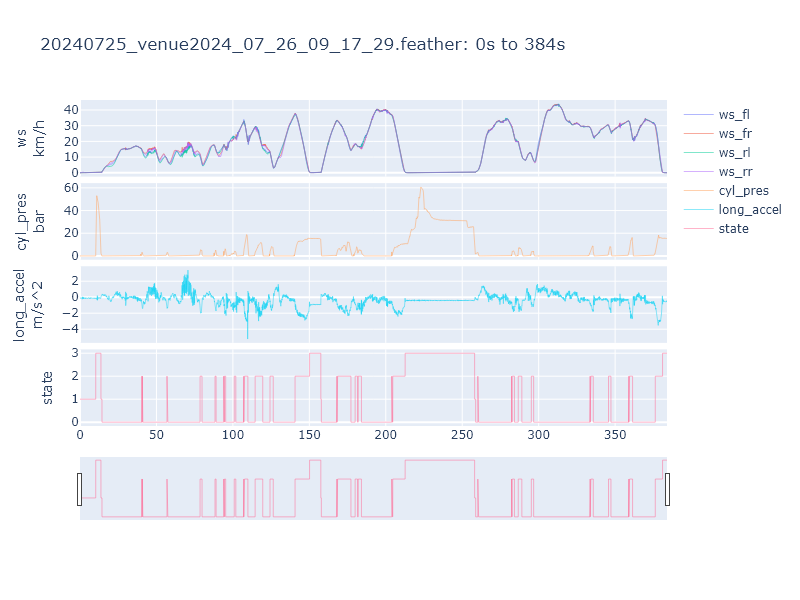

In [8]:
# 전체 트레이스의 그래프를 그려본다. 
fig_driving = draw_stop(df, feather.name)
png_driving = k_dir_project / f'{feather.stem}_driving.png'
fig_driving.write_image(png_driving)
img = Image.open(png_driving)
display(img)


- 제동 이벤들이 여러 개 포함되어 있다.

In [9]:
# 정차하는 시점의 타임스탬프를 구한다.
df['brake_state_shift'] = df['brake_state'].shift().fillna(0).astype(int)

# 직전(지난 틱)에 brake and vehicle moving 상태에서 이번(현재 틱)에 brake and vehicle stopped 상태로 변한 틱을 찾는다.
ts_stops = df.loc[(df['brake_state'] == 3) & ((df['brake_state_shift'] == 2)) , 'ts']

print(f'{len(ts_stops)}개의 정차 이벤트를 찾았습니다.')
print('정차 시점들 =')
print(ts_stops)

3개의 정차 이벤트를 찾았습니다.
정차 시점들 =
15108    150.16
21359    212.67
38224    381.03
Name: ts, dtype: float64


In [10]:
def get_df_stop(df, ts_stop):
    '''
    "제동 이벤트" 구간의 데이터를 추출한다.
    제동 이벤트는 제동을 시작하여 완전 정차할 때까지 구간을 말한다.
    ts_stop은 정차 시점의 타임스탬프이다. 
    정차 시점을 기준으로 1.5초 후까지의 데이터를 포함한다.
    정차 시점을 기준으로 제동 이벤트의 시작점을 찾는다.
    제동을 시작한 점에서 1.5초 전까지의 데이터를 포함한다.
    '''

    # 정차 후 1.5초 동안의 데이터를 포함한다.
    ts_end = ts_stop + 1.5

    # 제동 시작점을 찾는다. = brake_state가 1보다 클 때까지 이전으로 이동한다.
    # brake_state가 1보다 작을 때는 제동하지 않는 상태이다.
    ts_begin = ts_stop
    j = ts_stops[ts_stops == ts_stop].index[0]
    while df.iloc[j]['brake_state'] > 1:
        j -= 1

    # 제동 시작점을 기준으로 1.5초 전까지의 데이터를 포함한다.
    ts_begin = df.iloc[j]['ts'] - 1.5

    # 제동 구간을 데이터를 구한다.
    df_stop = df.loc[(df['ts'] >= ts_begin) & (df['ts'] <= ts_end)]

    if ts_end - ts_begin <= 5.0:
        df_stop = pd.DataFrame()

    return df_stop



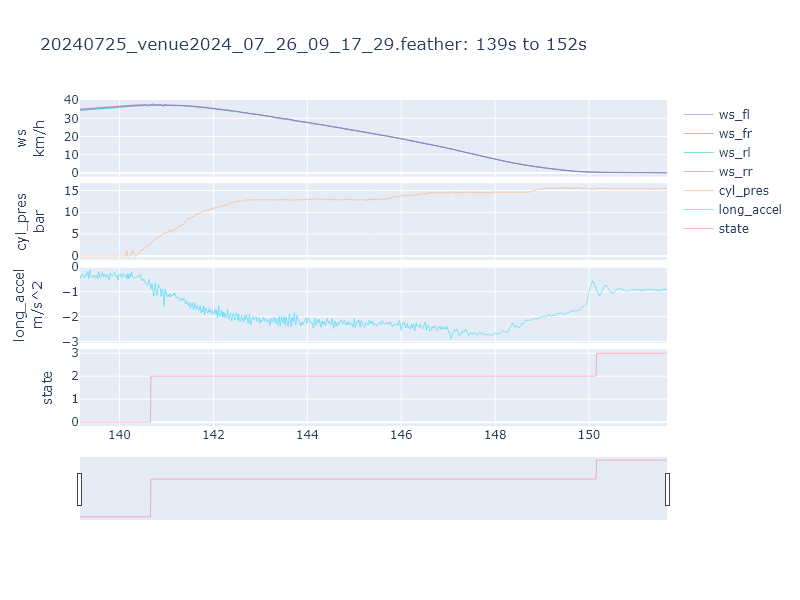

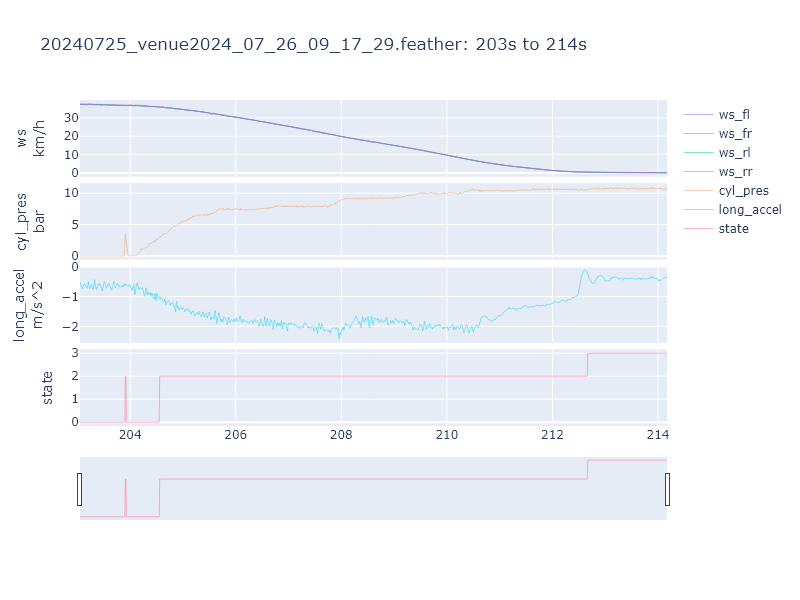

In [11]:
# 정차하는 시점을 기준으로 제동 구간을 찾는다.
# 제동 구간을 그래프로 그린다.

for ts_stop in ts_stops[:2]:
# for ts_stop in ts_stops:
    df_stop = get_df_stop(df, ts_stop)
    if not df_stop.empty:
        fig_stop = draw_stop(df_stop, feather.name)
        png_stop = k_dir_project / f'{feather.stem}_{ts_stop:.0f}_stop.png'
        fig_stop.write_image(png_stop)
        img = Image.open(png_stop)
        display(img)

### 발견 - 브레이크 페달을 밟을 때 cyl_pres 시그널에 스파이크 신호 발생
- 내가 브레이크 페달을 밟을 때, 위 그래프의 cyl_pres 트레이스 처럼 스파이크가 생기도록 빠르게 밟았다 뗐다가 다시 지그시 밟았을까? 저렇게 빠르게 밟았다가 뗄 수가 있을까?
- cy_pres 신호에 노이즈라고 생각한다. 원인이 무엇인지 모르겠지만. 
- 이런 현상은 데이터를 측정하지 않은 주관 평가만으로는 알 수 없다고 생각한다. 


### 발견 - 데이터 관리
- 제동 데이터를 분석하는 측면에서는 제동 이벤트 별로 데이터를 분할하여, 파일로 저장했다가, 분석이 필요할 때 해당 파일을 읽어서 계산하는 것이 시간 절약이 될 것이다. 파일을 저장할 때는 제동 시작 속도, 종료 속도, 직선/곡선 제동 등의 특징을 파일 이름에 포함한다면 파일 검색이 편리할 것이다.  
- 그런데 그렇게 하자면 파일이 정말 많이 생성될 것이고, 관리 대상 파일이 너무 많아서 관리가 어려울 수도 있겠다. 
- 프로그램이 하는 것이니까 파일이 많아도 큰 문제가 되지 않을 수 있다. 
- 파일을 분할하지 않고 그대로 보관하는 대신, 파일 안에 데이터를 이벤트 별로 분석하고 분석 내용을 데이터 파일의 메타 데이터 파일에 저장하는 방법을 적용할 수 있다. 메타 데이터 파일들을 검색해서 필요한 이벤트의 데이터 파일을 찾을 수도 있겠다. 
- 어쨌든 데이터 파일 관리가 필요하고 중요하다. 데이터의 재사용성을 높여서 시험 비용과 시간을 줄여야 한다.   

## 제동 이벤트 1개를 대상으로 디셀 유니포머티 (Deceleration Uniformity)를 계산한다.
- 제동 중 감속도가 떨어지는 부분이 있는지 판정하기 위한 지표이다.
- 시간 대 감속도 그래프에서 시간 축 위에 제동 시작점을 찍는다. 
    - 제동 유압이 2.5 bar를 이상이 되는 점을 제동 시작점으로 정의한다. 2.5 bar면 브레이크 패드와 디스크 사이의 간극이 완전히 사라지고 실제 제동력이 발생한다고 판단한다.
- 제동 시작점에 가상의 수직선을 긋는다. 제동 시작점을 중심으로 수직선을 반시계 방향으로 회전시키며 감속도 그래프와 접점을 찾는다. 
- 이 접점에 가상의 수직선을 긋는다. 이 접점을 중심으로 수직선을 반시계 방향으로 회전시키며 감속도 그래프와 접점을 찾는다. 새 접점이 제동 종료 시점을 넘을 때까지 위 단계를 반복한다. 
- 최종 접점의 시간이 제동 종료 시점보다 크면, 최종 접점의 위치를 제동 종료점으로 변경한다.
- 제동 시점과 접점들을 연결하여 만들어진 곡선을 기준 감속도 곡선이라고 하겠다.
- 기준 감속도 곡선과 시간 축 사이의 면적 대비 실제 감속도 곡선과 시간 축 사이의 면적의 비율을 디셀 유니포머티로 정의한다. 
- 디셀 유니포머티가 기준값 (예, 95%) 이하이면, 감속도가 떨어지는 부분을 집중 조사한다. ABS release가 과한가? ABS apply가 부족한가? 등 원인을 찾아 개선한다.



In [12]:
# 트레이스 안에 제동 이벤트가 몇 개나 있는 지 확인한다.
# 정차 시점의 타임스탬프들을 구하는 방식으로 이벤트 개수를 센다.
print('stop numbers to check:')
for i, ts_stop in enumerate(ts_stops):
    df_stop = get_df_stop(df, ts_stop)
    if not df_stop.empty:
        print(f'stop {i} : {ts_stop = :.1f}s')



stop numbers to check:
stop 0 : ts_stop = 150.2s
stop 1 : ts_stop = 212.7s
stop 2 : ts_stop = 381.0s


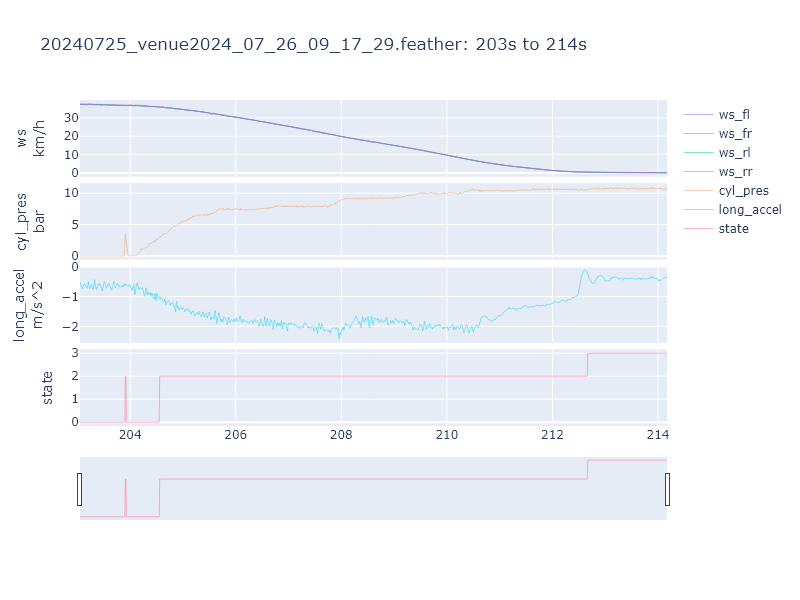

In [13]:
# i_stop번째 제동 이벤트를 대상으로 계산한다. 
i_stop = 1

df_stop = get_df_stop(df, ts_stops.iloc[i_stop])

# 제동 구간을 그래프로 그려 확인한다.
fig_stop = draw_stop(df_stop, feather.name)
png_stop = k_dir_project / f'{feather.stem}_{ts_stops.iloc[i_stop]:.0f}_stop.png'
fig_stop.write_image(png_stop)
img = Image.open(png_stop)
display(img)

In [14]:
def calc_ref_decel_profile(df_stop, ts_stop):
    '''    
    디셀 유니포머티를 계산하기 위한 기준 감속도 프로파일 계산 방법:
    - 시간 대 감속도 그래프에서 시간 축 위에 제동 시작점을 찍는다. 
    - 제동 유압이 2.5 bar를 이상이 되는 점을 제동 시작점으로 정의한다. 2.5 bar면 브레이크 패드와 디스크 사이의 간극이 완전히 사라지고 실제 제동력이 발생한다고 판단한다.
    - 제동 시작점에 가상의 수직선을 긋는다. 제동 시작점을 중심으로 수직선을 반시계 방향으로 회전시키며 감속도 그래프와 접점을 찾는다. 
    - 이 접점에 가상의 수직선을 긋는다. 이 접점을 중심으로 수직선을 반시계 방향으로 회전시키며 감속도 그래프와 접점을 찾는다. 새 접점이 제동 종료 시점을 넘을 때까지 위 단계를 반복한다. 
    - 최종 접점의 시간이 제동 종료 시점보다 크면, 최종 접점의 위치를 제동 종료점으로 변경한다.
    - 제동 시점과 접점들을 연결하여 만들어진 곡선을 기준 감속도 곡선이라고 하겠다.
    
    디셀 유니포머티의 정의:
    - 디셀 유니포머티는 기준 감속도 곡선과 시간 축 사이의 면적 대비 실제 감속도 곡선과 시간 축 사이의 면적의 비율을 디셀 유니포머티로 정의한다. 

    디셀 유니포머티의 활용:
    - 디셀 유니포머티가 기준값 (예, 95%) 이하이면, 감속도가 떨어지는 부분을 집중 조사한다. ABS release가 과한가? ABS apply가 부족한가? 등 원인을 찾아 개선한다.
    '''

    tss = []
    long_accels = []

    # 제동 시작점을 추가한다.
    p0 = df_stop.loc[df_stop['brake_state'] == 2, ['ts', 'long_accel']].iloc[0]
    tss.append(p0['ts'])
    long_accels.append(0.0)   

    tss.append(p0['ts'])
    long_accels.append(p0['long_accel'])   

    while tss[-1] < ts_stop:
        df_stop_tail = df_stop.loc[(df_stop['ts'] > tss[-1]) & (df_stop['ts'] <= ts_stop)].copy()
        df_stop_tail['grad'] = (df_stop_tail['long_accel'] - long_accels[-1]) / (df_stop_tail['ts'] - tss[-1])
        grad_min = df_stop_tail['grad'].min()
        p1 = df_stop_tail.loc[df_stop_tail['grad'] == grad_min, ['ts', 'long_accel']].iloc[0]
        tss.append(p1['ts'])
        long_accels.append(p1['long_accel'])
        if tss[-1] >= ts_stop:
            tss[-1] = ts_stop
            long_accels[-1] = df_stop.loc[df_stop['ts'] == ts_stop, 'long_accel'].iloc[0]

            tss.append(p1['ts'])
            long_accels.append(0.0)
    
    return tss, long_accels


In [15]:
tss, long_accels = calc_ref_decel_profile(df_stop, ts_stops.iloc[i_stop])

# tss와 long_accels 계산 결과
for ts, long_accel in zip(tss, long_accels):
    print(f'{ts = :.2f}, {long_accel = :.2f}')


ts = 203.91, long_accel = 0.00
ts = 203.91, long_accel = -0.65
ts = 204.09, long_accel = -0.93
ts = 204.86, long_accel = -1.51
ts = 205.64, long_accel = -1.91
ts = 207.96, long_accel = -2.42
ts = 210.42, long_accel = -2.22
ts = 210.50, long_accel = -2.18
ts = 212.27, long_accel = -1.16
ts = 212.32, long_accel = -1.13
ts = 212.47, long_accel = -0.99
ts = 212.48, long_accel = -0.97
ts = 212.67, long_accel = -0.24
ts = 212.67, long_accel = 0.00


In [16]:
def draw_decel_uniformity(df_stop, data_file_name, tss, long_accels, decel_uniformity, decel_mean, yaw_rate_mean = None):
    '''
    6 x 1의 subplots를 그린다.
    1번째 plot은 wheel_speeds를 그린다.
    2번째 plot은 long_accel와 tss, long_accels를 그린다.
    3번째 plot은 cyl_pres를 그린다.
    4번째 plot은 yaw_rate를 그린다. yaw_rate_mean을 표시한다.
    5번째 plot은 sas를 그린다
    6번째 plot은 lat_accel을 그린다.
    '''

    k_row = 6
    fig = make_subplots(rows=k_row, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['ws_fl'], mode='lines', name='ws_fl'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['ws_fr'], mode='lines', name='ws_fr'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['ws_rl'], mode='lines', name='ws_rl'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['ws_rr'], mode='lines', name='ws_rr'), row=1, col=1)
    # wheel speeds의 단위는 km/h이다. y축의 단위를 km/h로 표시한다.
    fig.update_yaxes(title_text='ws<br>km/h', row=1, col=1)

    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['long_accel'], mode='lines', name='long_accel'), row=2, col=1)
    fig.add_trace(go.Scatter(x=tss, y=long_accels, mode='markers+lines', name='long_accel_ref'), row=2, col=1)
    # long_accel의 단위는 m/s^2이다.
    fig.update_yaxes(title_text='long_accel<br>m/s^2', row=2, col=1)

    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['cyl_pres'], mode='lines', name='cyl_pres'), row=3, col=1)
    # cyl_pres의 단위는 bar이다.
    fig.update_yaxes(title_text='cyl_pres<br>bar', row=3, col=1)

    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['yaw_rate'], mode='lines', name='yaw_rate'), row=4, col=1)
    # yaw_rate의 단위는 degree/s이다.
    fig.update_yaxes(title_text='yaw_rate<br>degree/s', row=4, col=1)

    if yaw_rate_mean:
        fig.add_hline(y=yaw_rate_mean, line_dash='dot', line_color='red', annotation_text=f'yaw_rate_mean = {yaw_rate_mean:.2f}', row=4, col=1)

    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['sas'], mode='lines', name='sas'), row=5, col=1)
    # sas_angle의 단위는 degree이다.
    fig.update_yaxes(title_text='sas<br>degree', row=5, col=1)

    fig.add_trace(go.Scatter(x=df_stop['ts'], y=df_stop['lat_accel'], mode='lines', name='lat_accel'), row=6, col=1)
    # lat_accel의 단위는 m/s^2이다.
    fig.update_yaxes(title_text='lat_accel<br>m/s^2', row=6, col=1)
      

    # 선굵기를 0.5로 한다.
    for i_row in range(1, k_row + 1):
        fig.update_traces(line=dict(width=0.5), row=i_row, col=1)   

    fig.update_layout(
        title=f'{data_file_name}: {df_stop["ts"].min():.0f}s to {df_stop["ts"].max():.0f}s<br>{decel_uniformity = :.1f}% {decel_mean = :.1f}m/s^2', 
        height=800, 
        width=600, 
        showlegend=True
    )

    return fig

In [17]:
def calc_decel_uniformity(df_stop, tss, long_accels):
    '''
    디셀 유니포머티의 정의:
    - 디셀 유니포머티는 기준 감속도 곡선과 시간 축 사이의 면적 대비 실제 감속도 곡선과 시간 축 사이의 면적의 비율을 디셀 유니포머티로 정의한다. 
    '''

    # 디셀 유니포머티의 기준이 되는 tss[0] 부터 tss[-1]까지 long_accel의 적분을 구한다.
    area_ref_long_decel = -simpson(y=long_accels, x=tss)

    # tss[0] 부터 tss[-1]까지의 df_stop['long_accel']의 적분을 구한다.
    filt = ((df_stop['ts'] >= tss[0]) & (df_stop['ts'] <= tss[-1]))
    area_long_decel = -simpson(y=df_stop.loc[filt, 'long_accel'], x=df_stop.loc[filt, 'ts'])

    # decel_uniformity는 두 면적의 비율이다.
    decel_uniformity = area_long_decel / area_ref_long_decel * 100

    decel_mean = df_stop.loc[filt, 'long_accel'].mean()

    print(f'{area_ref_long_decel = :,.1f}\n{area_long_decel     = :,.1f}\n{decel_uniformity    = :.1f}%\n{decel_mean = :.1f}m/s^2')

    # return decel_uniformity, long_accels, decel_mean
    return decel_uniformity, decel_mean

## 제동 이벤트 1개에 대해서 제동 안정성 지표들을 계산한다.
- 직진 제동 중에 평균 요-레이트 (yaw_rate_mean)와 요-레이트 변동폭 (yaw_rate_ptp, peak to peak)은 제동의 안정성을 평가하는 지표다.
- 평균 요-레이트를 통해서 차가 정차했을 때 똑바로 섰는지를 평가할 수 있다.
- 요-레이트 변동폭을 통해서 차가 제동 중에 얼마나 많이 흔들렸는지를 평가할 수 있다.

In [18]:
def calc_stability_indexes(df_stop, tss):
    '''
    직진 제동 중에 yaw_rate_mean과 yaw_rate_ptp(peak to peak)은 제동의 안정성을 평가하는 지표다.
    yaw_rate_mean을 통해서 차가 정차했을 때 얼마나 똑바로 섰는지를 평가할 수 있다.
    yaw_rate_ptp을 통해서 차가 제동 중에 얼마나 많이 흔들렸는지를 평가할 수 있다.
    '''

    # tss[0] 부터 tss[-1]까지의 yaw_rate의 평균을 구한다.   
    filt = ((df_stop['ts'] >= tss[0]) & (df_stop['ts'] <= tss[-1]))
    yaw_rate_mean = df_stop.loc[filt, 'yaw_rate'].mean()

    # tss[0] 부터 tss[-1]까지의 peak-to-peak yaw_rate를 구한다.
    yaw_rate_ptp = df_stop.loc[filt, 'yaw_rate'].max() - df_stop.loc[filt, 'yaw_rate'].min()
                        
    print(f'{yaw_rate_mean = :,.2f} deg/s\n{yaw_rate_ptp  = :,.2f} deg/s')

    return yaw_rate_mean, yaw_rate_ptp

### 계산 - 디셀 유니포머티

In [19]:
# 디셀 유니포머티를 계산한다.
# decel_uniformity, long_accels, decel_mean = calc_decel_uniformity(df_stop, tss, long_accels)
decel_uniformity, decel_mean = calc_decel_uniformity(df_stop, tss, long_accels)

area_ref_long_decel = 16.9
area_long_decel     = 14.4
decel_uniformity    = 85.0%
decel_mean = -1.6m/s^2


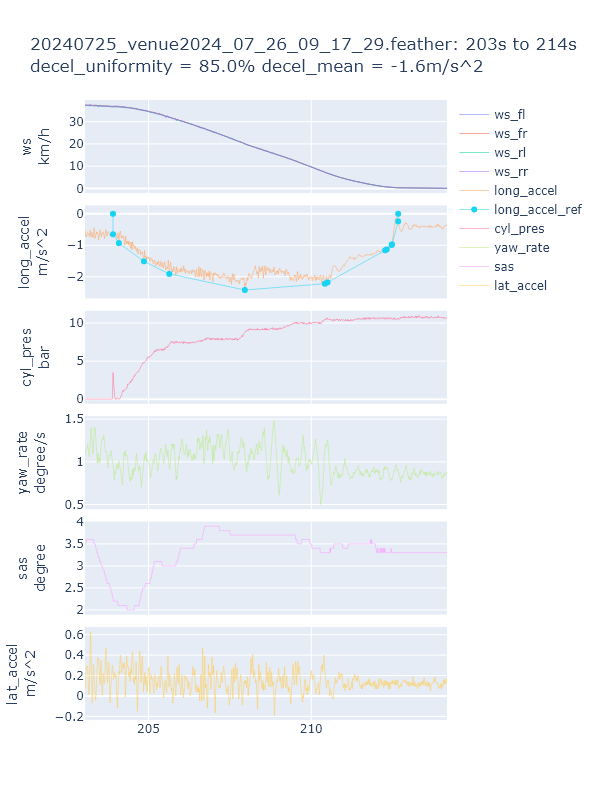

In [20]:
fig_decel_uniformity = draw_decel_uniformity(df_stop, feather.name, tss, long_accels, decel_uniformity, decel_mean)
png_decel_uniformity = k_dir_project / f'{feather.stem}_{ts_stops.iloc[i_stop]:.0f}_decel_uniformity.png'
fig_decel_uniformity.write_image(png_decel_uniformity)
img = Image.open(png_decel_uniformity)
display(img)

### 발견 - long_accel 오프셋
- 차량 정차 후에 long_accel이 0이 아니다.
- 정차 위치가 경사지라서 그럴 수도 있고, long_accel 센서의 캘리브레이션 오차가 있어서 그럴 수도 있다.
- 보정하기로 한다.

In [21]:
# 정차 후 1.5초 구간의 long_accel의 평균으로 long_accel의 오프셋을 구한다.
long_accel_offset = df_stop.loc[df_stop['ts'] > ts_stops.iloc[i_stop], 'long_accel'].mean()
print(f'{long_accel_offset = :.2f} m/s^2')

# long_accel의 오프셋을 보정한 한다. 
df_stop.loc[:, 'long_accel'] = df_stop.loc[:, 'long_accel'] - long_accel_offset

# 디셀 유니포머티 기준 프로파일의 오프셋을 보정한다.
# tss, long_accels = get_ref_decel_profile(df_stop, ts_stops.iloc[i_stop])
long_accels = [(long_accel - long_accel_offset) for long_accel in long_accels]
long_accels[0] = 0.0
long_accels[-1] = 0.0

# 다시 디셀 유니포머티를 계산한다.
decel_uniformity, decel_mean = calc_decel_uniformity(df_stop, tss, long_accels)

long_accel_offset = -0.41 m/s^2
area_ref_long_decel = 13.4
area_long_decel     = 10.8
decel_uniformity    = 80.6%
decel_mean = -1.2m/s^2


### 계산 - 제동 안정성
- yaw_rate_mean, yaw_rate_ptp을 계산한다.

In [22]:
yaw_rate_mean, yaw_rate_ptp = calc_stability_indexes(df_stop, tss)

yaw_rate_mean = 1.01 deg/s
yaw_rate_ptp  = 0.98 deg/s


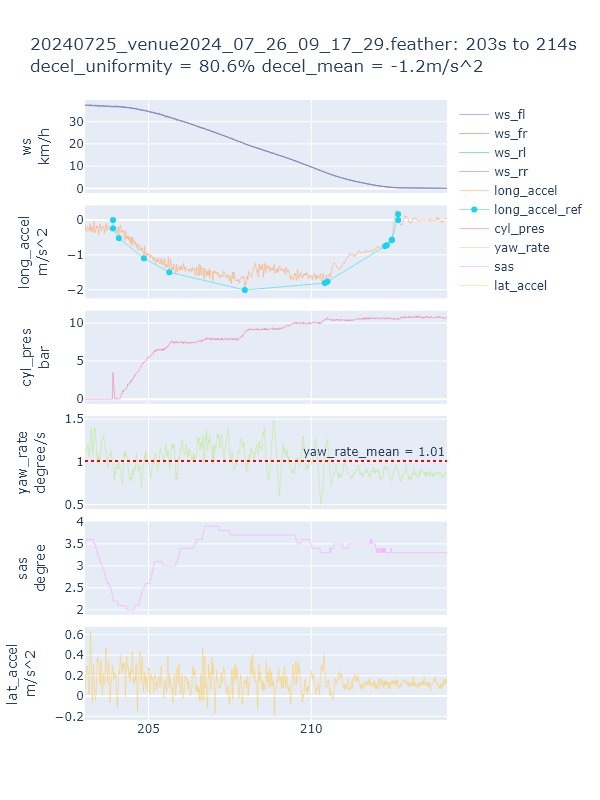

In [23]:
fig_ebs_perf_index = draw_decel_uniformity(df_stop, feather.name,  tss, long_accels, decel_uniformity, decel_mean, yaw_rate_mean)
png_ebs_perf_index = k_dir_project / f'{feather.stem}_{ts_stops.iloc[i_stop]:.0f}_ebs_perf_index.png'
fig_ebs_perf_index.write_image(png_ebs_perf_index)
img = Image.open(png_ebs_perf_index)
display(img)

### 결론 - 제동 이벤트 1개에 대해서 디셀 유니포머티를 계산한다.
- 위와 같이 하면 long_accel 센서 오프셋을 고려한 디셀 유니모머티를 계산할 수 있다.
- 디셀 유니포머티는 ABS 제동 성능을 평가하는 지표들 중에 하나다. 
    - ABS가 작동해야 한다.
    - 제동 중에 브레이크 페달을 밟는 힘(답력) 을 기준 이상으로 일정하게 유지해야 한다.
    - 직진 제동의 성능 평가를 위한 지표이다.
    - 데모 트레이스의 제동은
        - ABS 제동도 아니고
        - 답력을 기준 이상으로 유지하지도 않았고
        - 직진 제동이 아닌 경우도 있지만
    - 계산 방법을 설명하는 목적이기에 그냥 사용한다.
        - 제동 조건으로 필터를 만들어서 행당하는 제동 이벤트만 추출할 수 있다.
    

## 트레이스에 포함된 전체 제동 이벤트들에 대한 분석
- feather 파일이 있는 경우 아래 셀만 실행하면 된다. 

In [24]:
feathers = list(k_dir_data.glob('*.feather'))
print('feathers = ')
for i, feather in enumerate(feathers):
    print(f'{i}: {feather.name}')

i_feather = 0
feather = feathers[i_feather]

# Read feather file
df = pd.read_feather(feather)



feathers = 
0: 20240725_venue2024_07_26_09_17_29.feather


calculating decel uniformity for stop at 150.16 ...
area_ref_long_decel = 14.3
area_long_decel     = 11.0
decel_uniformity    = 76.9%
decel_mean = -1.2m/s^2
yaw_rate_mean = 1.09 deg/s
yaw_rate_ptp  = 3.60 deg/s


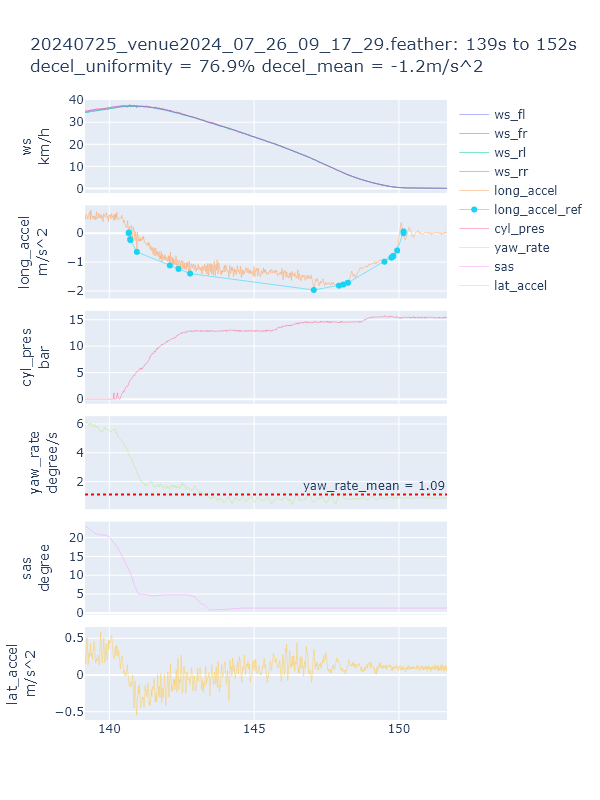


calculating decel uniformity for stop at 212.67 ...
area_ref_long_decel = 13.4
area_long_decel     = 10.8
decel_uniformity    = 80.6%
decel_mean = -1.2m/s^2
yaw_rate_mean = 1.01 deg/s
yaw_rate_ptp  = 0.98 deg/s


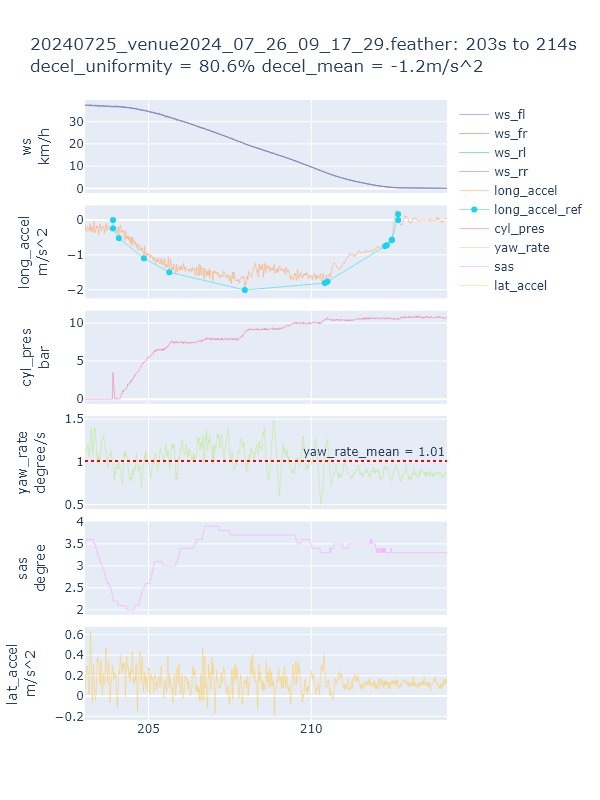

In [25]:
for ts_stop in ts_stops[:2]:
# for ts_stop in ts_stops:
    df_stop = get_df_stop(df, ts_stop)
    if not df_stop.empty:
        print(f'calculating decel uniformity for stop at {ts_stop:.2f} ...')
        # 정차 후 1.5초 구간의 long_accel의 평균으로 long_accel의 오프셋을 구한다.
        long_accel_offset = df_stop.loc[df_stop['ts'] > ts_stop, 'long_accel'].mean()

        # long_accel의 오프셋을 제거한다.
        df_stop.loc[:, 'long_accel'] = df_stop.loc[:, 'long_accel'] - long_accel_offset

        # 디셀 유니포머티 계산의 기준이 되는 디셀 프로파일을 구한다.
        tss, long_accels = calc_ref_decel_profile(df_stop, ts_stop)

        # 디셀 유니포머티를 계산한다.
        decel_uniformity, decel_mean = calc_decel_uniformity(df_stop, tss, long_accels)

        yaw_rate_mean, yaw_rate_ptp = calc_stability_indexes(df_stop, tss)
        
        # 디셀 유니포머티를 그래프로 그린다.
        fig_ebs_perf_index = draw_decel_uniformity(df_stop, feather.name, tss, long_accels, decel_uniformity, decel_mean, yaw_rate_mean)
        png_ebs_perf_index = k_dir_project / f'{feather.stem}_{ts_stop:.0f}_ebs_perf_index.png'
        fig_ebs_perf_index.write_image(png_ebs_perf_index)
        img = Image.open(png_ebs_perf_index)
        display(img)
        print()




### 결론
- 디셀 유니포머티는 제동 성능을 평가하는 유용한 지표이다.
- CAN 트레이스에는 디셀 유니포머티 계산에 필요한 신호들이 있다. 
- CAN 트레이스에서 디셀 유니포머티를 계산하는 것은 간단하다.


### TODO
- 제동의 다른 성능 지표들을 계산해본다.
- 예
    - 선회 제동 중 ...
    - 뮤 점프 중 ...
- 측정된 시그널들로 응용할 수 있는 다른 방법들을 생각해본다. 

